<a href="https://colab.research.google.com/github/LucaoCodes/TCC/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas-datareader statsmodels plotly python-bcb openpyxl --quiet


In [ ]:
# Bibliotecas
from bcb import sgs
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
import plotly.express as px
import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Selic é diária então quebramos a consulta em 3 períodos de até 10 anos
selic_00_09 = sgs.get(1178, start='2000-01-01', end='2009-12-31')
selic_10_19 = sgs.get(1178, start='2010-01-01', end='2019-12-31')
selic_20_24 = sgs.get(1178, start='2020-01-01', end='2024-12-31')
selic_full = pd.concat([selic_00_09, selic_10_19, selic_20_24])

selic_full = selic_full.sort_index() #Ordena pelo indice
selic_full.head()

,1178
Date,
2000-01-03,19.04
2000-01-04,19.04
2000-01-05,19.05
2000-01-06,19.07
2000-01-07,19.07


In [ ]:
#tratando os dados
selic_full['month'] = selic_full.index.to_period('M')  #mensall
br_selic = selic_full[~selic_full['month'].duplicated(keep='last')].drop(columns='month') #retirando duplicados e pegando ultimo valor
br_selic.index = br_selic.index.to_period('M')
br_selic.columns = ['br_selic']
br_selic.head()

,br_selic
Date,
2000-01,18.90
2000-02,18.87
2000-03,18.52
2000-04,18.62
2000-05,18.44


In [ ]:
# IDs utilizados pelo SGS
series_ids = {
    'br_ipca': 433,# IPCA (inflação)
    'br_pib': 4380,# PIB (Trimestral)
    'br_exp_ipca': 4385,# Expectativa IPCA 12 meses
    'br_exp_selic': 4390,# Expectativa Selic
    'br_exp_pib': 4382,# Expectativa PIB
    #'br_ibcbr': 24363,# IBC-Br (proxy do PIB) calculado a partir de 2003
}

df_brasil = sgs.get(list(series_ids.values()), start='2000-01-01', end='2024-12-31') #Extraindo com o periodo desejado
df_brasil.head()

,433,4380,4385,4390,4382
Date,,,,,
2000-01-01,0.62,92576.6,49367,1.46,1099350.8
2000-02-01,0.13,91770.4,51269,1.45,1110192.1
2000-03-01,0.22,92579.9,54284,1.45,1113969.4
2000-04-01,0.42,91376.2,52099,1.30,1117606.6
2000-05-01,0.01,98727.0,54569,1.49,1127110.5


In [ ]:
#tratamentos
df_brasil.columns = series_ids.keys() #Renomear colunas com ids
df_brasil['br_exp_ipca'] = df_brasil['br_exp_ipca'] / 10000 #considerar exp_ipca como %
df_brasil.index = df_brasil.index.to_period('M')

In [ ]:
df_brasil.head()

,br_ipca,br_pib,br_exp_ipca,br_exp_selic,br_exp_pib
Date,,,,,
2000-01,0.62,92576.6,4.9367,1.46,1099350.8
2000-02,0.13,91770.4,5.1269,1.45,1110192.1
2000-03,0.22,92579.9,5.4284,1.45,1113969.4
2000-04,0.42,91376.2,5.2099,1.30,1117606.6
2000-05,0.01,98727.0,5.4569,1.49,1127110.5


In [ ]:
# IDs utilizados pelo yahoo finance BR
series_ids_yf_br = {
    'br_ibov': '^BVSP',#Ibovespa
    'br_ewz': 'EWZ',#ewz (a partir do mes 7 apenas)
}

tickers = list(series_ids_yf_br.values())
df_br_yf = yf.download(tickers, start='2000-01-01', end='2024-12-31')['Close']
df_br_yf.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


Ticker,EWZ,^BVSP
Date,,
2000-01-03,NaN,16930.0
2000-01-04,NaN,15851.0
2000-01-05,NaN,16245.0
2000-01-06,NaN,16107.0
2000-01-07,NaN,16309.0


In [ ]:
#tratando os dados
# Mapeamento reverso para garantir correspondência correta
ticker_map = {v: k for k, v in series_ids_yf_br.items()}
df_br_yf.columns = [ticker_map[ticker] for ticker in df_br_yf.columns]
df_br_yf.head()

df_br_yf = df_br_yf.resample('M').last()
df_br_yf.index = df_br_yf.index.to_period('M')
df_br_yf.head()

<ipython-input-9-1962b15ab7d4>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_br_yf = df_br_yf.resample('M').last()


,br_ewz,br_ibov
Date,,
2000-01,NaN,16388.0
2000-02,NaN,17660.0
2000-03,NaN,17820.0
2000-04,NaN,15538.0
2000-05,NaN,14957.0


In [ ]:
#juntando bases
br_full = pd.concat([br_selic, df_brasil, df_br_yf], axis=1)
br_full.head()

,br_selic,br_ipca,br_pib,br_exp_ipca,br_exp_selic,br_exp_pib,br_ewz,br_ibov
Date,,,,,,,,
2000-01,18.90,0.62,92576.6,4.9367,1.46,1099350.8,NaN,16388.0
2000-02,18.87,0.13,91770.4,5.1269,1.45,1110192.1,NaN,17660.0
2000-03,18.52,0.22,92579.9,5.4284,1.45,1113969.4,NaN,17820.0
2000-04,18.62,0.42,91376.2,5.2099,1.30,1117606.6,NaN,15538.0
2000-05,18.44,0.01,98727.0,5.4569,1.49,1127110.5,NaN,14957.0


In [ ]:
#analise basica df
print("Informações gerais da base:\n")
print(f"Linha/Coluna: {br_full.shape}")
print("\nTipos de dados:")
print(br_full.dtypes)

print("\n Valores nulos por coluna:")
print(br_full.isnull().sum())

print("\nEstatísticas descritivas:")
display(br_full.describe())

Informações gerais da base:

Linha/Coluna: (300, 8)

Tipos de dados:
br_selic        float64
br_ipca         float64
br_pib          float64
br_exp_ipca     float64
br_exp_selic    float64
br_exp_pib      float64
br_ewz          float64
br_ibov         float64
dtype: object

 Valores nulos por coluna:
br_selic        0
br_ipca         0
br_pib          0
br_exp_ipca     0
br_exp_selic    0
br_exp_pib      0
br_ewz          6
br_ibov         0
dtype: int64

Estatísticas descritivas:


,br_selic,br_ipca,br_pib,br_exp_ipca,br_exp_selic,br_exp_pib,br_ewz,br_ibov
count,300.000000,300.000000,3.000000e+02,300.000000,300.000000,3.000000e+02,294.000000,300.000000
mean,12.195433,0.501133,4.274779e+05,13.613497,0.953933,4.929864e+06,22.628149,60912.620000
std,4.976098,0.394905,2.559464e+05,5.608696,0.377069,2.958524e+06,10.493238,34410.242654
min,1.900000,-0.680000,9.137620e+04,3.623400,0.130000,1.099351e+06,2.494907,8623.000000
25%,8.837500,0.260000,1.953456e+05,8.840975,0.720000,2.233145e+06,16.149486,36579.500000
50%,11.920000,0.450000,3.999756e+05,15.090700,0.930000,4.606581e+06,24.326087,56814.500000
75%,15.300000,0.675000,5.852583e+05,17.830250,1.180000,6.915387e+06,29.353774,85394.750000
max,26.320000,3.020000,1.050160e+06,23.456200,2.080000,1.174471e+07,47.510399,136004.000000


In [ ]:
# IDs utilizados pelo yahoo finance EUA
series_ids_yf_eua = {
    'eua_sp500': '^GSPC',        # S&P 500
    'eua_nasdaq': '^IXIC',      # NASDAQ
    'eua_vix': '^VIX',     # Volatilidade (VIX)
}

df_eua_yf = yf.download(list(series_ids_yf_eua.values()), start='2000-01-01', end='2024-12-31')['Close'] #Extraindo com o periodo desejado
df_eua_yf.head()

[*********************100%***********************]  3 of 3 completed


Ticker,^GSPC,^IXIC,^VIX
Date,,,
2000-01-03,1455.219971,4131.149902,24.209999
2000-01-04,1399.420044,3901.689941,27.010000
2000-01-05,1402.109985,3877.540039,26.410000
2000-01-06,1403.449951,3727.129883,25.730000
2000-01-07,1441.469971,3882.620117,21.719999


In [ ]:
#tratando os dados
df_eua_yf.columns = series_ids_yf_eua.keys() #Renomear colunas com ids
df_eua_yf = df_eua_yf.resample('M').last() #trazer apenas ultimo valor do mês (fechamento mensal)
df_eua_yf.index = df_eua_yf.index.to_period('M') #YYYY-MM
df_eua_yf.head()

<ipython-input-13-4ed02f704826>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_eua_yf = df_eua_yf.resample('M').last() #trazer apenas ultimo valor do mês (fechamento mensal)


,eua_sp500,eua_nasdaq,eua_vix
Date,,,
2000-01,1394.459961,3940.350098,24.950001
2000-02,1366.420044,4696.689941,23.370001
2000-03,1498.579956,4572.830078,24.110001
2000-04,1452.430054,3860.659912,26.200001
2000-05,1420.599976,3400.909912,23.650000


In [ ]:
# IDs utilizados pelo pandas_datareader EUA
series_ids_web = {
    'eua_juros': 'FEDFUNDS', # Taxa de juros (Fed)
    'eua_inflacao': 'CPIAUCSL',# Inflação (CPI)
    'eua_pib': 'GDP',# PIB (EUA)
}

df_eua_web = web.DataReader(list(series_ids_web.values()), 'fred' , start='2000-01-01', end='2024-12-31') #Extraindo com o periodo desejado
df_eua_web.head()

,FEDFUNDS,CPIAUCSL,GDP
DATE,,,
2000-01-01,5.45,169.3,10002.179
2000-02-01,5.73,170.0,NaN
2000-03-01,5.85,171.0,NaN
2000-04-01,6.02,170.9,10247.720
2000-05-01,6.27,171.2,NaN


In [ ]:
#tratando
df_eua_web.columns = series_ids_web.keys() #Renomear colunas com ids
df_eua_web.index = df_eua_web.index.to_period('M')
df_eua_web['eua_pib'] = df_eua_web['eua_pib'].resample('M').interpolate(method='linear') #preenchendo valores nulos do pib trimestral
df_eua_web['eua_inflacao'] = df_eua_web['eua_inflacao'] / 10000
df_eua_web.head()

<ipython-input-15-7ac99625192d>:4: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df_eua_web['eua_pib'] = df_eua_web['eua_pib'].resample('M').interpolate(method='linear') #preenchendo valores nulos do pib trimestral


,eua_juros,eua_inflacao,eua_pib
DATE,,,
2000-01,5.45,0.01693,10002.179000
2000-02,5.73,0.01700,10084.026000
2000-03,5.85,0.01710,10165.873000
2000-04,6.02,0.01709,10247.720000
2000-05,6.27,0.01712,10271.201667


In [ ]:
eua_full = pd.concat([df_eua_yf, df_eua_web], axis=1)
eua_full.head()

,eua_sp500,eua_nasdaq,eua_vix,eua_juros,eua_inflacao,eua_pib
2000-01,1394.459961,3940.350098,24.950001,5.45,0.01693,10002.179000
2000-02,1366.420044,4696.689941,23.370001,5.73,0.01700,10084.026000
2000-03,1498.579956,4572.830078,24.110001,5.85,0.01710,10165.873000
2000-04,1452.430054,3860.659912,26.200001,6.02,0.01709,10247.720000
2000-05,1420.599976,3400.909912,23.650000,6.27,0.01712,10271.201667


In [ ]:
#analise basica df
print("Informações gerais da base:\n")
print(f"Linha/Coluna: {eua_full.shape}")
print("\nTipos de dados:")
print(eua_full.dtypes)

print("\n Valores nulos por coluna:")
print(eua_full.isnull().sum())

print("\nEstatísticas descritivas:")
display(eua_full.describe())

Informações gerais da base:

Linha/Coluna: (300, 6)

Tipos de dados:
eua_sp500       float64
eua_nasdaq      float64
eua_vix         float64
eua_juros       float64
eua_inflacao    float64
eua_pib         float64
dtype: object

 Valores nulos por coluna:
eua_sp500       0
eua_nasdaq      0
eua_vix         0
eua_juros       0
eua_inflacao    0
eua_pib         0
dtype: int64

Estatísticas descritivas:


,eua_sp500,eua_nasdaq,eua_vix,eua_juros,eua_inflacao,eua_pib
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2116.647496,5473.346862,19.934200,1.919600,0.022992,17436.153510
std,1251.151600,4513.133785,7.942330,2.022275,0.003817,5255.627435
min,735.090027,1172.060059,9.510000,0.050000,0.016930,10002.179000
25%,1206.157501,2174.602478,13.987500,0.140000,0.020045,13740.568667
50%,1490.239990,3349.209961,17.885000,1.215000,0.022900,16300.803333
75%,2726.792603,7444.877563,23.725000,3.530000,0.025228,20744.275500
max,6032.379883,19486.789062,59.889999,6.540000,0.031760,29723.864000


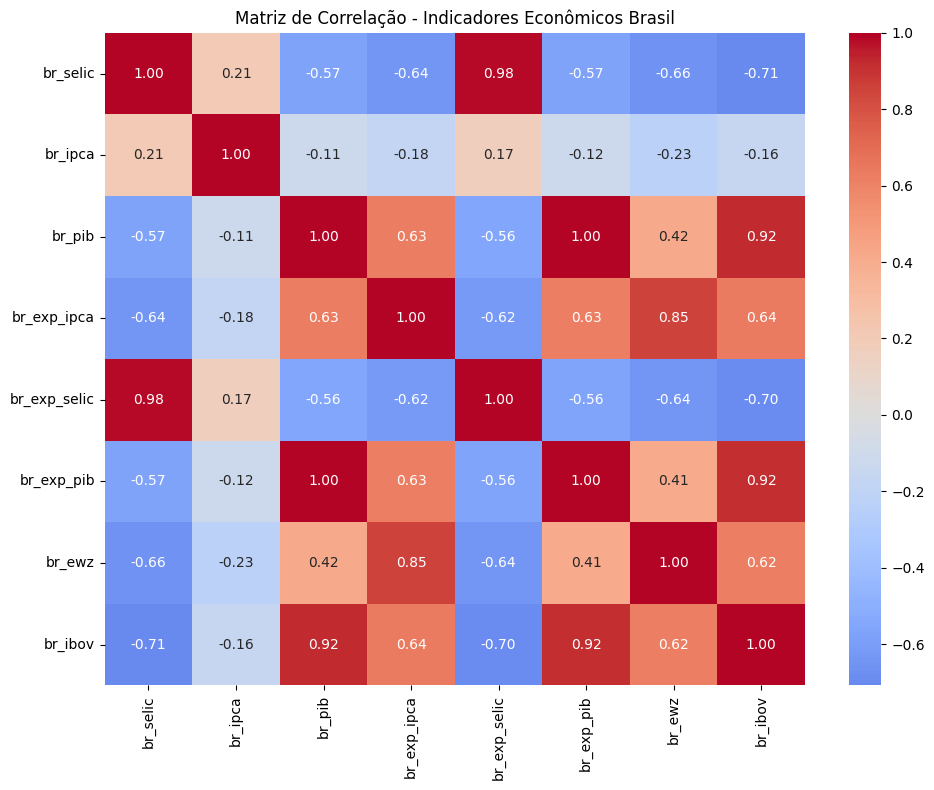

In [ ]:
# Análise Brasil
br_corr = br_full.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(br_corr, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Matriz de Correlação - Indicadores Econômicos Brasil')
plt.tight_layout()
plt.show()

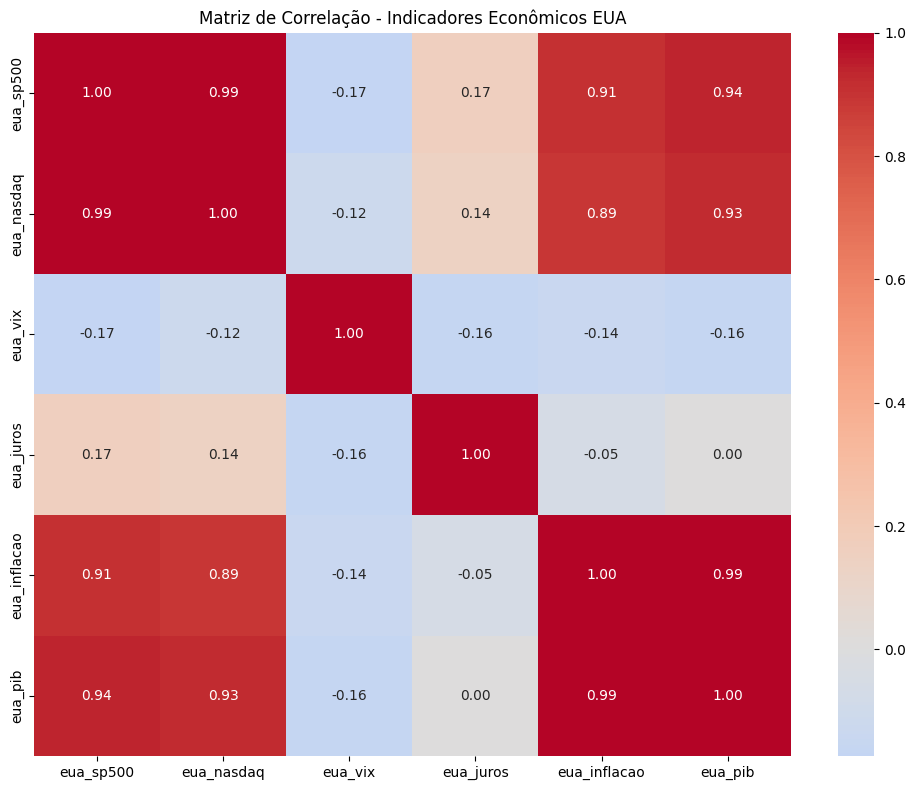

In [ ]:
# Análise EUA
eua_corr = eua_full.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(eua_corr, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Matriz de Correlação - Indicadores Econômicos EUA')
plt.tight_layout()
plt.show()

In [ ]:
br_full.to_csv('br_full.csv')